In [3]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')
from FEMSystem import FEMSystem

# Remaining Imports
import jax.numpy as jnp
import skfem as fem
from jaxopt import LBFGS
import jax
import matplotlib.pyplot as plt

## Create a 3D Mesh

Starting Part 1: Creating the Mesh
Part 1 Finished: Mesh Created
Degrees of Freedom: 1000


 --------------- 




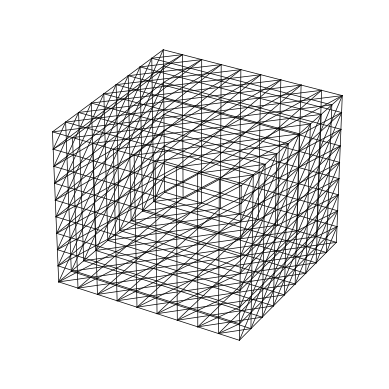

In [4]:
print("Starting Part 1: Creating the Mesh")
# Create the FEMSystem Object
granularity = 10 # number of mesh elements
X = jnp.linspace(0, 1, granularity)
Y = jnp.linspace(0, 1, granularity)
Z = jnp.linspace(0, 1, granularity)

# Define the mesh
mesh = fem.MeshTet.init_tensor(X,Y,Z)

# Scale and center in 3D
L = 60.0
mesh = mesh.scaled(2 * L).translated((-L, -L,-L))

# Define the unit Tetrehedral Element
element = fem.ElementTetP1()
intorder = 4

# Now define the FEMSystem
femsystem = FEMSystem(mesh,element,intorder,boundary_condition=0,saveFigsDir=None)
print("Part 1 Finished: Mesh Created")
print(f"Degrees of Freedom: {femsystem.dofs}")
print("\n\n --------------- \n\n")


# VISUALIZE THE MESH
import matplotlib.pyplot as plt
import skfem.visuals.matplotlib as vis

# Draw the 3D mesh edges
vis.draw(mesh)
plt.show()

In [5]:
# Step 1: Define the Geometry of two cubic islands:
seps = jnp.arange(1,40,0.1)
int_areas = []

separation = 10
sideLen = 20
centerLeft,centerRight = ((sideLen+separation)/2,0,0), (-(sideLen+separation)/2,0,0)
area = 2 * (sideLen ** 3)

def theta(x_vec):
    x,y,z = x_vec[0],x_vec[1],x_vec[2]
    cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2) & (jnp.abs(z-centerLeft[2]) <= sideLen / 2)
    cond2 = (jnp.abs(x-centerRight[0]) <= sideLen / 2) & (jnp.abs(y-centerRight[1]) <= sideLen / 2) & (jnp.abs(z-centerRight[2]) <= sideLen / 2)
    return cond1 | cond2

def theta_right_only(x_vec):
    x,y,z= x_vec[0],x_vec[1],x_vec[2]
    cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2) & (jnp.abs(z-centerLeft[2]) <= sideLen / 2)
    return cond1


theta_at_dofs = theta(femsystem.doflocs).astype(jnp.float32)
integrated_area = femsystem.integrate(lambda u,grad_u,x: u,theta_at_dofs)
print(f"Area: {area} | Integrated Area Estimate: {integrated_area}")

Area: 16000 | Integrated Area Estimate: 37925.9296875


In [ ]:
'''
Helper Functions for Integrals
'''

def laplacian(u,grad_u,x):
    return -1*jnp.sum(grad_u**2,axis=0)

# For Potential Energy Double Inetgral, u1 is our function phi_{+/-} and u2 is theta. 
def u_squared(u,grad_u,u2,grad_u2,x):
    return u**2

# Define Pre-Computed Values for Theta and Green's Function:
def theta_func(u,grad_u,u2,grad_u2,x):
    return u2

# U_{++++} or U_{----}, Really N * \alpha
def alpha(u,G_mat):
    return integrated_area  * femsystem.double_integral(lambda u1,a,b,c,d: u1**2,lambda u1,a,b,c,d: u1**2,G_mat,u,u)

# U_{+--+} = U{-++-} - Remember middle two are wrt to y, Outer two wrt to x, from notation used in doc
def beta(u1_arg,u2_arg,G_mat):
    return integrated_area * femsystem.double_integral(lambda u1,a,b,c,d: u1**2, lambda a,b,u2,c,d: u2**2, G_mat, u1_arg,u2_arg)

# U_{++--} = U{+-+-}
def gamma(u1_arg,u2_arg,G_mat):
    return integrated_area * femsystem.double_integral(lambda u1,a,u2,c,d: u1*u2, lambda u1,b,u2,c,d: u1*u2, G_mat, u1_arg,u2_arg)

'''
Helper Functions for Matrices
'''

def Sx(N):
    return Sz(N)

def Sy(N):
    return Sz(N) 

def Sz(N):
    j = (N-1)/2
    diagonals = j - jnp.arange(N)
    return jnp.diag(diagonals)

def offDiag(N):
    ones_super = jnp.ones(N - 1, dtype=jnp.int32)
    ones_sub = jnp.ones(N - 1, dtype=jnp.int32)
    super_diag_matrix = jnp.diag(ones_super, k=1)
    sub_diag_matrix = jnp.diag(ones_sub, k=-1)
    result = super_diag_matrix + sub_diag_matrix
    return result

def expval(mat,vec):
    return jnp.vdot(vec,mat @ vec)

def normalize_vec(vec):
    norm_v = jnp.linalg.norm(vec)
    # normalized_v = jnp.where(jnp.isclose(norm_v, 0.0), vec, vec / norm_v )
    return vec / norm_v

# get first N as the vector of coeffs, remaining as u_interior
def unpack(vec,N):
    coeff_vec,u = vec[:N],vec[N:]
    return coeff_vec,u

def guess_gaussian(N,stddevs=4):
    x = jnp.linspace(-stddevs, stddevs, N)
    mu,sigma = 0.0,1.0
    exponent = -jnp.square(x - mu) / (2.0 * jnp.square(sigma))
    gaussian_array = jnp.exp(exponent)
    return gaussian_array

# VERY VERY IMPORTANT TO PASS IN G_mat AS AN ARGUMENT, AND SET TO CONSTANT IN OPTIMIZATION LOOP
# This is because when JAX compiles this function, it will treat the G_mat as a "tracer", so just any matrix of constants with some shape. 
# If you hardcode it into the function, it will treat it as an actual part of the code and will spent time compiling a massive amount of hardcoded values as "code" essentially. This is why it takes almost 10 minutes to run first optimization iteration. 
# @jax.jit

def epsilon_func(u_global,G_mat,theta_at_dofs):
    # Kinetic Term
    kinetic = -4 * femsystem.integrate(laplacian,u_global)

    # Potential Term
    potential = -2 * femsystem.double_integral(u_squared,theta_func,G_mat,u_global,theta_at_dofs)

    return kinetic  + potential

def E(u_global,G_mat,theta_at_dofs):
    return epsilon_func(u_global,G_mat,theta_at_dofs) + alpha(u_global,G_mat)


'''
Before you start the optimization loop:
1. Define Objective
2. Compute Interaction Kernel
3. Get Initial Guess
'''

# Set constants
N = 50 # Number of coefficients. NOTE: Just set this to an outside variable. Lots of trouble trying to pass into a dynamical argument, since JAX doesn't like when array indices are dynamical. 

# 1. Defining Objective
@jax.jit
def objective(vec,G_mat,theta_at_dofs):
    # Unpack the modes from the coefficients
    coeff_vec,u_interior = unpack(vec,N)

    # Normalize Coeff Vector: 
    coeff_vec = normalize_vec(coeff_vec)

    # Unpack even and odd modes
    u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_interior)
    E_plus,E_minus = E(u_even,G_mat,theta_at_dofs), E(u_odd,G_mat,theta_at_dofs)


    # Construct Objective
    zeropoint = (E_plus + E_minus) / 2
    hz = E_plus - E_minus
    spinZ = offDiag(N) / 5
    term1 = expval(spinZ,coeff_vec) * hz

    print("Vals:",zeropoint,term1)
    print("Coeffs:",coeff_vec)

    return zeropoint # + term1

# 2. Computing Interaction Kernel
epsilon = 1e-20
def G(x_vec,y_vec):
    # return 1 / jnp.sqrt(jnp.sum((x_vec-y_vec)**2,axis=-1)) + epsilon
    return - 1 / (2*jnp.pi) * jnp.log(jnp.sqrt(jnp.sum((x_vec-y_vec)**2,axis=-1)) + epsilon)

theta_at_dofs = theta(femsystem.doflocs)

# G_mat = femsystem.get_sparse_interaction_mat(G)


# 2. Computing Interaction Kernel
G_mat = femsystem.get_greens_kernel()

# 3. Getting Initial Guess
coeff_vector_init = guess_gaussian(N) / 10
u_interior_init = femsystem.ones_on_island(theta_right_only)
initial_guess = jnp.concatenate((coeff_vector_init, u_interior_init), axis=0)

'''
Testing, for a sanity check, and to do a jit compilation
'''
temp = objective(initial_guess,G_mat,theta_at_dofs)

# print(f"Plotting the Initial Guess")
# femsystem.plot_at_interior_2d_in3d(u_interior_init)
# x = (N-1)/2 - jnp.arange(N)
# plt.scatter(x,coeff_vector_init)

/scratch/gpfs/AROD/vc9839/finite-island-cqed/jax-gpu/lib64/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/scratch/gpfs/AROD/vc9839/finite-island-cqed/jax-gpu/lib64/python3.9/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Vals: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
Coeffs: Traced<ShapedArray(float32[50])>with<DynamicJaxprTrace(level=1/0)>


: 

In [8]:
print(temp)

-95.84325


In [ ]:
# Optimization Loop
print("Starting Optimization")
solver = LBFGS(fun=objective,tol=1e-2,verbose=True)
result = solver.run(initial_guess,G_mat,theta_at_dofs)
result = result.params 
coeffs,u_interior = unpack(result,N)

Starting Optimization
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 1.4426805973052979 Objective Value:-96.22915649414062  Stepsize:0.07921987026929855  Number Linesearch Iterations:3 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 1.4463881254196167 Objective Value:-96.37232971191406  Stepsize:1.0  Number Linesearch Iterations:5 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 1.2935459613800049 Objective Value:-96.9106674194336  Stepsize:0.2041037529706955  Number Linesearch Iterations:2 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 1.074407696723938 Objective Value:-96.96806335449219  Stepsize:0.30615562200546265  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 0.5949479937553406 Objective Value:-97.0350341796875  Stepsize:0.45923343300819397  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 0.27182719111442566 Objective

: 

In [1]:
# Plot Solution

# Get Even and Odd Modes
u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_interior)
u_even_interior,u_odd_interior = u_even[femsystem.interior_dofs],u_odd[femsystem.interior_dofs]

NameError: name 'femsystem' is not defined

In [ ]:
x = (N-1)/2 - jnp.arange(N)
plt.scatter(x,coeffs)